In [1]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class text_Dataset(Dataset):
    def __init__(self, annotations_file):
        self.csv_object = pd.read_csv(annotations_file)

    def __len__(self):
        return len(self.csv_object)

    def __getitem__(self, idx):
        text = self.csv_object.iloc[idx]['text']
        label = self.csv_object.iloc[idx]["label"]
        return text, label


In [15]:
from tqdm.notebook import tqdm

def eval(model, dataloader, tokenizer):
    model.eval()
    eval_loss = torch.nn.CrossEntropyLoss()
    total_eval_loss = []
    accuracy_graph = []
    for i, (text, label) in enumerate(tqdm(dataloader)):
        batch = tokenizer(list(text), padding="max_length", truncation=True)
        batch.update({"labels": label})
        batch = {k: torch.tensor(v).to(device).type(torch.long) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        total_eval_loss.append(eval_loss(logits.cpu(), label).cpu())
        
        acc = (torch.sum(predictions.cpu() == label)/label.shape[0]).item()
        accuracy_graph.append(acc)


    return sum(total_eval_loss)/len(total_eval_loss), sum(accuracy_graph)/len(accuracy_graph)

# Train

In [3]:
train_dataloader = DataLoader(text_Dataset("dataset/train_set.csv"), batch_size=16)
val_dataloader = DataLoader(text_Dataset("dataset/val_set.csv"), batch_size=32)
test_dataloader = DataLoader(text_Dataset("dataset/test_set.csv"), batch_size=32)

In [6]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, AdamW, AutoTokenizer, get_scheduler
from tqdm.notebook import tqdm
import numpy as np
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

training_args = TrainingArguments("test_trainer")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#   ---

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)


model.train()

progress_bar = tqdm(range(num_training_steps))

training_loss = []

i = 0

for epoch in tqdm(range(num_epochs)):
    epoch_loss = []
    for text, label in train_dataloader:
        i += 1

        batch = tokenizer(list(text), padding="max_length", truncation=True)
        batch.update({"labels": label})
        batch = {k: torch.tensor(v).to(device).type(torch.long) for k,v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        epoch_loss.append(outputs.loss.clone().cpu().detach().item())
        
        if i % 250 == 0:
          print(f"{i} : {epoch_loss[-1]}")

    training_loss.append(sum(epoch_loss)/len(epoch_loss))


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


250 : 0.017035501077771187
500 : 0.0019829575903713703
750 : 0.0006627585389651358
1000 : 0.0016894802683964372


KeyboardInterrupt: ignored

# Tests and training graph

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


torch.Size([16, 3])

tensor([2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0], device='cuda:0')

tensor([2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0])



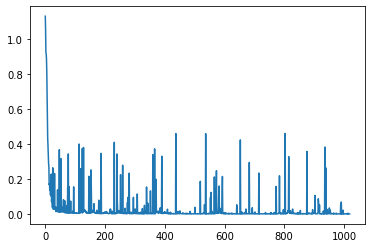

In [10]:
import matplotlib.pyplot as plt
plt.plot(epoch_loss)

itr_ = iter(train_dataloader)
text, label = next(itr_)
model.eval()
with torch.no_grad():
    
    batch = tokenizer(list(text), padding="max_length", truncation=True)
    batch.update({"labels": label})
    batch = {k: torch.tensor(v).to(device).type(torch.long) for k,v in batch.items()}
    outputs = model(**batch)
    print(outputs.logits.shape)

logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

# print(text)
print()
print(predictions)
print()
print(label)

print()


In [17]:
loss_val, accuracy_val =  eval(model, test_dataloader, tokenizer)
print(f"validation loss: {loss_val} validation accuracy: {accuracy_val}")

  0%|          | 0/1052 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


validation loss: 0.005765737034380436 validation accuracy: 0.9985029940119761


In [18]:
torch.save(model, "model.pth")